In [44]:
import string
import random
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader

def split_names_to_char_list(file_name):
    EOS = "<EOS>"
    data = []

    with open(file_name) as file:
        text = file.read()

    names = text.lower().splitlines()
    for name in names:
        ch_list = list(name) + [EOS]
        data.append(ch_list)
    return data

data_in_char = split_names_to_char_list("dinos.txt")
print(f'Sample data {data_in_char[0]}')

vocab = []
for ch in string.ascii_lowercase:
    vocab.append(ch)
vocab.append("<EOS>")
print(f'Vocabulary : {vocab}')

dict_char_int = {ch:i for i,ch in enumerate(vocab)}

def keys_to_values(keys, map, default):
    return [map.get(key, default) for key in keys]

Sample data ['a', 'a', 'c', 'h', 'e', 'n', 'o', 's', 'a', 'u', 'r', 'u', 's', '<EOS>']
Vocabulary : ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '<EOS>']


In [45]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, string_data, map):
        self.data_as_int = []

        # Convert characters to integers
        for seq_as_str in string_data:
            seq_as_int = keys_to_values(seq_as_str, map,
                random.choice(list(map)))

            self.data_as_int.append(seq_as_int)

    def __len__(self):
        return len(self.data_as_int)

    def __getitem__(self, ix):
        # Get data sample at index ix
        item = self.data_as_int[ix]

        # Slice x and y from sample
        x = item[:-1]
        y = item[ 1:]
        return torch.tensor(x), torch.tensor(y)

dataset = Dataset(data_in_char, dict_char_int)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

def random_train():
    name = random.choice(data_in_char)
    return name

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, len(vocab))
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][vocab.index(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [vocab.index(line[li]) for li in range(1, len(line))]
    letter_indexes.append(len(vocab) - 1) # EOS
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    line = random_train()
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return input_line_tensor, target_line_tensor

criterion = nn.CrossEntropyLoss()

learning_rate = 0.0005

rnn = RNN(len(vocab), 128, len(vocab))

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = torch.Tensor([0]) # you can also just simply use ``loss = 0``

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [46]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('Iteration: %d Progress: %d%% Loss: %.4f' % (iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0


Iteration: 5000 Progress: 5 Loss: 2.6316
Iteration: 10000 Progress: 10 Loss: 1.2714
Iteration: 15000 Progress: 15 Loss: 1.3324
Iteration: 20000 Progress: 20 Loss: 2.8603
Iteration: 25000 Progress: 25 Loss: 1.5065
Iteration: 30000 Progress: 30 Loss: 1.4900
Iteration: 35000 Progress: 35 Loss: 1.6049
Iteration: 40000 Progress: 40 Loss: 1.4489
Iteration: 45000 Progress: 45 Loss: 2.4262
Iteration: 50000 Progress: 50 Loss: 1.9498
Iteration: 55000 Progress: 55 Loss: 2.1906
Iteration: 60000 Progress: 60 Loss: 1.5240
Iteration: 65000 Progress: 65 Loss: 1.3286
Iteration: 70000 Progress: 70 Loss: 1.6361
Iteration: 75000 Progress: 75 Loss: 1.3471
Iteration: 80000 Progress: 80 Loss: 1.1815
Iteration: 85000 Progress: 85 Loss: 1.1346
Iteration: 90000 Progress: 90 Loss: 1.3670
Iteration: 95000 Progress: 95 Loss: 1.0256
Iteration: 100000 Progress: 100 Loss: 1.6758


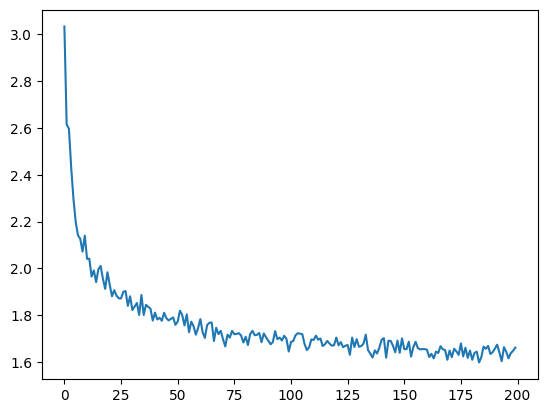

In [47]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [62]:
def generate(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter
        letter = ""

        while letter != "<EOS>":
            output, hidden = rnn(input[0], hidden)
            _, topi = output.topk(1)
            topi = topi[0][0]
            if topi == len(vocab) - 1:
                break
            else:
                letter = vocab[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name
num_gen = 20
name_list = []
for i in range(num_gen):
  ch = random.choice(vocab)
  if len(ch) != 1:
    ch = random.choice(vocab)
  name = generate(ch)
  name_list.append(name)
  print(f' Character: {ch}, Name: {name}')

 Character: l, Name: lianosaurus
 Character: r, Name: ratosaurus
 Character: k, Name: kurisaurus
 Character: i, Name: iangosaurusaus
 Character: s, Name: sianosaurus
 Character: z, Name: zalosausus
 Character: a, Name: auruchentosaurus
 Character: p, Name: palodonisaurus
 Character: g, Name: gongongosaurus
 Character: y, Name: yranosaurus
 Character: d, Name: dongongonauruc
 Character: c, Name: ceratops
 Character: b, Name: baritenotosausus
 Character: a, Name: aurustenos
 Character: y, Name: yranosaurus
 Character: v, Name: vusaurus
 Character: u, Name: urisaurus
 Character: d, Name: dongonganas
 Character: g, Name: gongonosaurus
 Character: g, Name: gostorus


In [63]:
import csv

def save_as_csv(data_list, file_path):
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for item in data_list:
            writer.writerow([item])
save_as_csv(name_list, 'Generated_dinos.csv')